# CSCA-5642: Kaggle Cancerous Cell Detection Project #
#### Develop an algorithm that identifies metastatic cancer in small image patches from digital pathology scans. ####
    
* Author: Alexander Meau  
* Email: alme9155@colorado.edu  
* GitHub: [https://github.com/alme9155/csca-5642-week3/tree/main](https://github.com/alme9155/csca-5642-week3/tree/main)  


## I. Brief description of the problem and data ##

This project aims to tackle Kaggle's Cancer Detection challenge to identify cancerous cell images from non-cancerous using Convolutional Neural Network (CNN). The challenge is to create an algorithm to identify metastatic cancer in small image patches taken from larget digital pathlogy scans. The data of this Kaggle competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. 
### Dataset: ####
* The training dataset contains about 220,025 image patches already labeled 1 as cancerous, 0 as non-cancerous in "train_labels.csv".
* A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.
* Tumor tissue in the outer region of the patch does not influence the label. 

### Data Size and Dimension ####
* Training dataset: 220,025 tiff images
* Test dataset: 57,458 tiff images (~26% of training size)
* Each image patch is 96x96 pixel of RGB color images in tiff formats.
* Label CSV contains 2 columns: id, label (1 as cancerous, 0 as non-cancerous)

### Competition Rules ###
* Expected submission CSV files in the same format as "train_labels.csv" with two columns "id, label". (id: unique id from test set, label: 0, or 1)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
tif_files = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"\nos path: [{dirname}]")
    tif_file_count =0
    for filename in filenames:
        if filename.endswith('.tif'):
            tif_file_count +=1
            if tif_file_count < 3:
                print(os.path.join(dirname, filename))
            elif tif_file_count == 3:
                print("...")
        else:
            print(os.path.join(dirname, filename))  
    if tif_file_count > 0:
        print(f"\nTotal number of .tif files in {dirname}: {tif_file_count}")
        tif_file_count =0

        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


os path: [/kaggle/input]

os path: [/kaggle/input/competitions]

os path: [/kaggle/input/competitions/histopathologic-cancer-detection]
/kaggle/input/competitions/histopathologic-cancer-detection/sample_submission.csv
/kaggle/input/competitions/histopathologic-cancer-detection/train_labels.csv

os path: [/kaggle/input/competitions/histopathologic-cancer-detection/test]
/kaggle/input/competitions/histopathologic-cancer-detection/test/a7ea26360815d8492433b14cd8318607bcf99d9e.tif
/kaggle/input/competitions/histopathologic-cancer-detection/test/59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
...

Total number of .tif files in /kaggle/input/competitions/histopathologic-cancer-detection/test: 57458

os path: [/kaggle/input/competitions/histopathologic-cancer-detection/train]
/kaggle/input/competitions/histopathologic-cancer-detection/train/d43c081bafa286f9c1f7e921883f26ceafebc912.tif
/kaggle/input/competitions/histopathologic-cancer-detection/train/092d0eedebce504847715ee046b6ad74b57599b4.tif


## II. Exploratory Data Analysis (EDA) ##
File: "train_label.csv"
- Inspect file columns, duplciates and null labels.
- Pre-process data frame to add 'train_filepath' for ease access to locate the files
- Pre-process data to convert 'label' as string
- Drop any rows in the dataset where corresponding .tif file path is missing.

In [3]:
import pandas as pd
import os 

train_labels = pd.read_csv('/kaggle/input/competitions/histopathologic-cancer-detection/train_labels.csv')
print("shape:",train_labels.shape)
print("-- Label head ---")
print("################")
print(train_labels.head())
print("-----------------")
print("Missing values: ")
print("################")
print(train_labels.isnull().sum())
print("-----------------")
print(f"Sum of duplicated labels: {train_labels.duplicated().sum()}.")

shape: (220025, 2)
-- Label head ---
################
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
-----------------
Missing values: 
################
id       0
label    0
dtype: int64
-----------------
Sum of duplicated labels: 0.


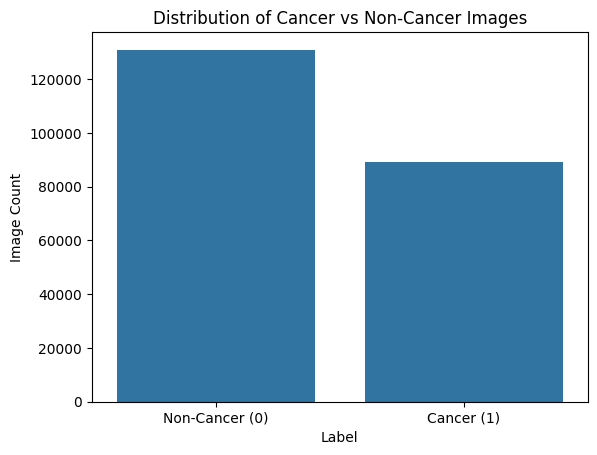

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train_labels)
plt.xticks([0, 1], ['Non-Cancer (0)', 'Cancer (1)'])
plt.title("Distribution of Cancer vs Non-Cancer Images")
plt.ylabel("Image Count")
plt.xlabel("Label")
plt.show()


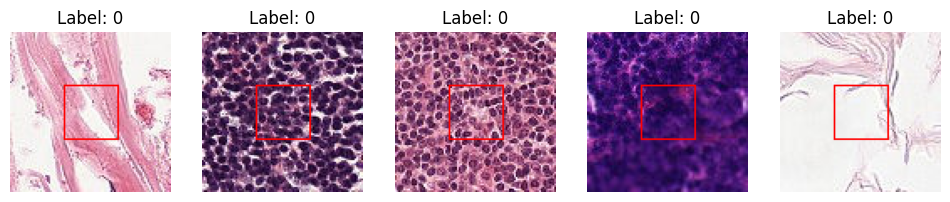

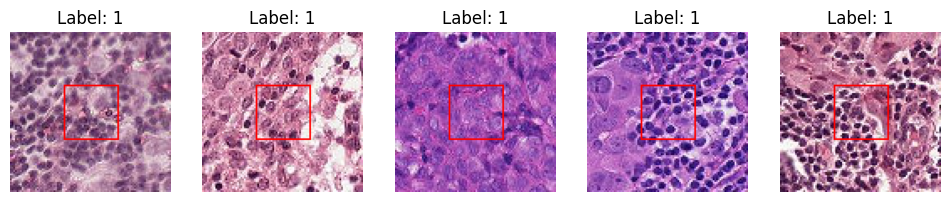

image size: (96, 96)
image mode: RGB


In [7]:
### show sample image files
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# add 'train_filepath' to dataframe
train_dir = Path("/kaggle/input/competitions/histopathologic-cancer-detection/train")
train_labels = pd.read_csv('/kaggle/input/competitions/histopathologic-cancer-detection/train_labels.csv')
train_labels['train_filepath'] = train_labels['id'].apply(lambda x: str(train_dir / f'{x}.tif'))
# # convert 'label' field to string.
# train_labels['label'] = train_labels['label'].astype(str)

# show sample file
def show_samples(label, df=train_labels, num_images=5):
    subset = df[df['label'] == label].sample(num_images, random_state=42)
    plt.figure(figsize=(12, 4))
    for i, row in enumerate(subset.itertuples()):
        img = cv2.imread(row.train_filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        center = (32, 32, 64, 64)  
        cv2.rectangle(img, (center[0], center[1]), (center[2], center[3]), (255, 0, 0), 1)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Label: {row.label}')
        plt.axis('off')
    plt.show()


show_samples(0)  # Non-cancerous
show_samples(1)  # Cancerous

# check image size and channel
img_path = f"/kaggle/input/competitions/histopathologic-cancer-detection/train/{train_labels['id'].iloc[0]}.tif"
img = Image.open(img_path)
print(f"image size: {img.size}") 
print(f"image mode: {img.mode}") 

In [8]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2026-02-19 10:50:26.500344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771498226.736843      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771498226.807500      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771498227.367681      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771498227.367724      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771498227.367727      55 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU available: []


2026-02-19 10:50:53.421085: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Pre-process the data ###

- Preprocess and split the data 80/20 into training and validation dataset
- Prepare load_image method to be used
- Prepare tensor pipeline to load image, label pair in mini-batch of 64

In [ ]:
from sklearn.model_selection import train_test_split
import cv2


# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(
    train_labels,
    test_size=0.2,
    stratify=train_labels['label'],
    random_state=42
)

def load_image(path, label):
    def _load_image_py(path_tensor):
        path_str = path_tensor.numpy()
        if isinstance(path_str, bytes):
            path_str = path_str.decode("utf-8")
        img = cv2.imread(path_str)
        if img is None:
            raise ValueError(f"Failed to load image at path: {path_str}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img.astype(np.uint8)

    image = tf.py_function(func=_load_image_py, inp=[path], Tout=tf.uint8)
    image.set_shape([96, 96, 3])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)  
    return image, label

# Create training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['train_filepath'], train_df['label']))
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['train_filepath'], val_df['label']))
validation_dataset = validation_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

print("Data Pre-processing complete..")

## III. Model Architecture ##

### Model Description ###

- This model implements traditional CNN model with three layers architecture.
- Model begins with 32 filters, and then this hyperparameter value doubled of each subsequent layer: 32, 64, 128 
- Since each image size is 96 x 96 pixel of RGB channel, input shape = (96,96, 3)
- To avoid overfitting, each convolution block is matched with pooling layer and batch-normalization.
- First layer use 5x5 kernel to learn major feature and then 3x3 kernel following inspiration of VGG-16. 

#### Reference ###
- Ref: https://www.geeksforgeeks.org/computer-vision/vgg-16-cnn-model
- Ref: https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

<img src="https://developers.google.com/static/machine-learning/practica/image-classification/images/cnn_architecture.svg" width="600">

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

#input shape = 96x 96x 3 (width x height x RGB)
cnn_model = Sequential([
    # First CNN block 
    Conv2D(32, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2), 
    
    # Second CNN block
    Conv2D(64, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2), 
    
    # Third CNN block
    Conv2D(128, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=2, strides=2), 
    
    # Output layer
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
cnn_model.summary()
three_layer_history = cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

print("\nTraining Metrics:")
print("---------------------------")
for metric in ['loss', 'accuracy', 'auroc']:
    print(f"{metric.capitalize()}: {three_layer_history.history[metric][-1]:.4f}")

print("\nValidation Metrics:")
print("---------------------------")
for metric in ['val_loss', 'val_accuracy', 'val_auroc']:
    print(f"{metric.replace('val_', 'Validation ').capitalize()}: {three_layer_history.history[metric][-1]:.4f}")



# show confusion matrix
y_true = []
y_pred = []
for images, labels in validation_dataset:
    preds = cnn_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())
y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix (Validation DataSet)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nConfusion Matrix Metrics:")
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


# Training loss vs Validation Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(three_layer_history.history['loss'], label='Training Loss')
plt.plot(three_layer_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(three_layer_history.history['accuracy'], label='Training Accuracy')
plt.plot(three_layer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC 
plt.subplot(1, 3, 3)
plt.plot(three_layer_history.history['auroc'], label='Training AUC')
plt.plot(three_layer_history.history['val_auroc'], label='Validation AUC')
plt.title('Training vs Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## IV. Result Analysis Before Fine-Tuning ##

- Overall, this CNN model performs moderately for the histopathologic cancer detection task before tuning, as it has a simple architecture and achieves 87% accuracy on the validation dataset. 

### Details ###
- At the end, this simplistic CNN model achieves 94% accuracy in the training dataset, but drops accuracy to 87% in the validation set. The drop in accuracy suggested that the model might have overfit the training dataset.
- The curve of training loss starts at 0.4 and decreases steadily to 0.1 around epoch 8. However, validation loss spikes sharply, and this suggest the model is memorizing the training data rather than generalizing it.
- The accuracy curve follows similiar patterns as in the curve of the training loss. Even though there are spikes with the validation curve, the validation accuracy improved gradually.
- Spikes are also observed in the AUC curve, but it did achieve the highest value of 0.97, suggesting the model is highly effective despite fluctuations.


## V. Explore Different CNN Model Architectures ##

My approach to explore different Convolutional Neural Network (CNN) architectures is as follows:

- Compare CNN model performance of same layout with higher and lower convolution layers
  - **2 convolutional layers**
  - **3 convolutional layers**
  - **5 convolutional layers**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

#Two convolutional block architecture
two_layer_cnn_model = Sequential([
    Conv2D(32, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    # Output layer
    Flatten(),Dropout(0.5),
    Dense(256, activation='relu'),Dropout(0.3), Dense(1, activation='sigmoid') 
])

two_layer_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
two_layer_history = two_layer_cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

print("\nTraining Metrics:")
print("---------------------------")
for metric in ['loss', 'accuracy', 'auroc']:
    print(f"{metric.capitalize()}: {two_layer_history.history[metric][-1]:.4f}")

print("\nValidation Metrics:")
print("---------------------------")
for metric in ['val_loss', 'val_accuracy', 'val_auroc']:
    print(f"{metric.replace('val_', 'Validation ').capitalize()}: {two_layer_history.history[metric][-1]:.4f}")


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC

#input shape = 96x 96x 3 (width x height x RGB)
five_layer_cnn_model = Sequential([
    Conv2D(32, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(128, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(256, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(512, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
        
    # Output layer
    Flatten(),Dropout(0.5),
    Dense(256, activation='relu'),Dropout(0.3), Dense(1, activation='sigmoid') 
])

five_layer_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
five_layer_history = five_layer_cnn_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

print("\nTraining Metrics:")
print("---------------------------")
for metric in ['loss', 'accuracy', 'auroc']:
    print(f"{metric.capitalize()}: {five_layer_history.history[metric][-1]:.4f}")

print("\nValidation Metrics:")
print("---------------------------")
for metric in ['val_loss', 'val_accuracy', 'val_auroc']:
    print(f"{metric.replace('val_', 'Validation ').capitalize()}: {five_layer_history.history[metric][-1]:.4f}")


In [ ]:
import matplotlib.pyplot as plt

histories = {
    "2-layer CNN": two_layer_history,
    "3-layer CNN": three_layer_history,
    "5-layer CNN": five_layer_history
}

metrics = ['accuracy', 'val_accuracy']
titles = {
    'accuracy': 'Training Accuracy',
    'val_accuracy': 'Validation Accuracy'
}

for metric in ['accuracy', 'val_accuracy']:    
    plt.figure(figsize=(6, 4))
    for label, history in histories.items():
        plt.plot(history.history[metric], label=label)
    plt.title(f"{titles[metric]} Comparison")
    plt.xlabel("Epoch")
    plt.ylabel(metric.split('_')[-1].capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

records = []
for name, hist in histories.items():
    max_train_accuracy = max(hist.history['accuracy'])
    max_val_accuracy = max(hist.history['val_accuracy'])
    last_train_accuracy = hist.history['accuracy'][-1]
    last_val_accuracy = hist.history['val_accuracy'][-1]
    train_loss = hist.history['loss'][-1]
    val_loss = hist.history['val_loss'][-1]
    max_auroc = max(hist.history['val_auroc'])
    last_auroc = hist.history['val_auroc'][-1]    
    records.append({
        "Model": name,
        "Max Training Accuracy": round(max_train_accuracy, 4),
        "Max Validation Accuracy": round(max_val_accuracy, 4),
        "Last Train Acc": round(last_train_accuracy, 4),
        "Last Val Acc": round(last_val_accuracy, 4),
        "Train Loss": round(train_loss, 4),
        "Val Loss": round(val_loss, 4),
        "Max Val AUC": round(max_auroc, 4),
        "Last Val AUC": round(last_auroc, 4)         
    })
metrics_df = pd.DataFrame(records)
metrics_df

## VI. Performance Analysis with Different Model Architectures ##

- Deeper model achieve higher traing and validation accuracy
  - 5 layer CNN reach 97% training accuracy, compared to 94% (3 layers), and 84% (2 layers)
  - 5 layer CNN reach 93% training accuracy, compared to 88% (3 layers), and 86% (2 layers)
  - Deeper network have greater capacity to learn more complex pattern

- Deeper model may introduce higher risk of overfitting
  - 5 layer model have relatively deeper gap between training and validation accuracy.
  - Performance gap widens with depth, suggesting a higher risk of overfitting and early stopping is required (next performance tuning).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Training loss vs Validation Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(five_layer_history.history['loss'], label='Training Loss')
plt.plot(five_layer_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss \n(Best Model Architecture)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(five_layer_history.history['accuracy'], label='Training Accuracy')
plt.plot(five_layer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy \n(Best Model Architecture)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC 
plt.subplot(1, 3, 3)
plt.plot(five_layer_history.history['auroc'], label='Training AUC')
plt.plot(five_layer_history.history['val_auroc'], label='Validation AUC')
plt.title('Training vs Validation AUC \n(Best Model Architecture)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## VII. Hyper-parameter Fine-Tuning by reducing Number of Filters ##

* **Validation accuracy lower than training accuracy** indicates **overfitting**, where the model performs well on training data but fails to generalize to unseen data.
* Overfitting may result from too many filters that learn noise patterns from the training data.
* Less number of filters encouraging to focus on essential patterns rather than memorizing training data.

- Three set number of filters be used for performance comparison:
  - (16, 32, 64, 128, 256), 
  - (24, 48, 96, 192, 384)
  - (32, 64, 128, 256, 512) (best model architecture)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC


filter_config = [(16, 32, 64, 128, 256), (24, 48, 96, 192, 384)]
# add previous model result
history_dict = {} 
history_dict[(32, 64, 128, 256, 512)] = five_layer_history
best_validation_accuracy = five_layer_history.history['val_accuracy'][-1]
best_filter_config = (32, 64, 128, 256, 512)
best_filter_history = five_layer_history

for idx, (f1, f2, f3, f4, f5) in enumerate(filter_config):
    filter_label = (f1, f2, f3, f4, f5)
    print(f"\nTraining Model with Filters: {filter_label}...")
    # best model architecture (5 layers)
    model_filter_tuning = Sequential([
        Conv2D(f1, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f2, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f3, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f4, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f5, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
            
        # Output layer
        Flatten(),Dropout(0.5),
        Dense(256, activation='relu'),Dropout(0.3), Dense(1, activation='sigmoid') 
    ])

        
    model_filter_tuning.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
    history_filter_tuning = model_filter_tuning.fit(train_dataset, validation_data=validation_dataset, epochs=10, verbose=1)
    history_dict[filter_label] = history_filter_tuning
    final_validation_accuracy =  history_filter_tuning.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy for {filter_label}: {final_validation_accuracy:.4f}")

    # Update best if current model is better
    if final_validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = final_validation_accuracy
        best_filter_config = filter_label
        best_filter_history = history_filter_tuning

print("Best Filter Configuration:")
print(f"Filters: {best_filter_config}")
print(f"Validation Accuracy: {best_validation_accuracy:.4f}")

In [ ]:
# Table of performance comparison
records_filter = []
for name, hist in history_dict.items():
    max_train_accuracy = max(hist.history['accuracy'])
    max_val_accuracy = max(hist.history['val_accuracy'])
    last_train_accuracy = hist.history['accuracy'][-1]
    last_val_accuracy = hist.history['val_accuracy'][-1]
    train_loss = hist.history['loss'][-1]
    val_loss = hist.history['val_loss'][-1]
    max_auroc = max(hist.history['val_auroc'])
    last_auroc = hist.history['val_auroc'][-1]
    
    records_filter.append({
        "name": name,
        "Max Train Accuracy": round(max_train_accuracy, 4),
        "Max Validation Accuracy": round(max_val_accuracy, 4),
        "Last Train Acc": round(last_train_accuracy, 4),
        "Last Validation Acc": round(last_val_accuracy, 4),
        "Train Loss": round(train_loss, 4),
        "Validation Loss": round(val_loss, 4),
        "Max Train AUC": round(max_auroc, 4),
        "Last Validation AUC": round(last_auroc, 4)        
    })
metrics_df_filter = pd.DataFrame(records_filter)
metrics_df_filter

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


# Training loss vs Validation Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(best_filter_history.history['loss'], label='Training Loss')
plt.plot(best_filter_history.history['val_loss'], label='Validation Loss')
plt.title(f"Training vs Validation Loss  \n(Best Num of Filters {best_filter_config}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(best_filter_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_filter_history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f"Training vs Validation Accuracy \n(Best Num of Filters {best_filter_config}")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC 
plt.subplot(1, 3, 3)
plt.plot(best_filter_history.history['auroc'], label='Training AUC')
plt.plot(best_filter_history.history['val_auroc'], label='Validation AUC')
plt.title(f"Training vs Validation AUC \n(Best Num of Filters {best_filter_config}")
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## VIII. Result Analysis after Fine-Tuning "Number of Filters" Hyper-parameter ##

### Result ###
- Despite fluctuation, CNN Model with filter configuration (32, 64, 128, 256, 512) achieve the higest validation accuracy 93% and validation AUC (0.97)
- CNN Model with configuration (24, 48, 96, 192, 384) has high training performance (0.96), but validation accuracy peaked at 0.92 (< 0.97)
- CNN Model with configuration (16, 32, 64, 128, 256) has worst validation result with AUC drop to 0.84

### Key Insights to why or why not the hyper-parameter fine-Tuning worked ###
Background:
- All three filter configurations perform better on training data than the validation dataset.
- This suggest model is overfitted to the training data and fails to generalize to unseen data.
- Theoretically, a lower number of filters should reduce noise patterns from the training set.

What worked:
- The spike in the validation history suggests that the model has learned enough useful features to achieve a high AUC score, but still requires further regularization.
- Even though fewer filter configurations (24, 48, 96, 192, 384) might have improved regularization, they do not learn enough complex features to exceed the original (32, 64, 128, 256, 512) filter configuration.
- Filter configuration (16, 32, 64, 128, 256) performs the worst because it lacks the capacity to capture complex patterns.
- Thus, for the best model submission, **filter configurations (32, 64, 128, 256, 512) remains the best choice.**


## IX. Hyper-parameter Fine-Tuning by reducing learning rates and early stopping ##

* A higher learning rate allows for faster convergence but risks overlooking the minimum and causing fluctuations.
* A lower learning rate should provide more stable convergence, but it also risks getting stuck in local minima.

- Three set learning rates will be used to study effect of this hyper-parameter: 
  - Learning rate = 0.0005 
  - Learning rate = 0.001 *(default value)*
  - Learning rate = 0.005

- A slower learning rate requires more epochs to reach minima. Thus, the epoch is doubled to 20 compared to the rest of the settings (epoch=10)

In [ ]:
import tensorflow as tf

# default lr = 0.001
optimizer = tf.keras.optimizers.Adam()
default_lr = optimizer.learning_rate.numpy()
print(f"Default learning rate: {default_lr}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# increase number of epoch to 50 as learning rate decreases
learning_rates_to_epoch = {
    5e-4: 20,   # (lower learning rate: 0.0005)
    5e-3: 10    # (higher learning rate=0.005)
}

history_dict_lr = {} 
history_dict_lr[default_lr] = five_layer_history
best_lr_validation_accuracy = five_layer_history.history['val_accuracy'][-1]
best_lr = default_lr
best_lr_history = five_layer_history

for lr, num_epochs in learning_rates_to_epoch.items():
    print(f"\nTraining Model with Learning Rate: {lr}...")
    
    model_lr_tuning = Sequential([
        Conv2D(f1, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f2, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f3, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f4, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
    
        Conv2D(f5, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
            
        # Output layer
        Flatten(),Dropout(0.5),
        Dense(256, activation='relu'),Dropout(0.3), Dense(1, activation='sigmoid') 
    ])


    model_lr_tuning.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])

    # Early stopping and keep best result
    early_stopping = EarlyStopping(monitor='val_auroc', patience=3, mode='max', restore_best_weights=True)
    history_lr_turning = model_lr_tuning.fit(train_dataset, validation_data=validation_dataset,epochs=num_epochs, callbacks=[early_stopping])
    history_dict_lr[lr] = history_lr_turning
    final_lr_validation_accuracy =  history_lr_turning.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy for {lr}: {final_lr_validation_accuracy:.4f}")
    
    if final_lr_validation_accuracy > best_lr_validation_accuracy:
        best_lr_validation_accuracy = final_lr_validation_accuracy
        best_lr = lr
        best_lr_history = history_lr_turning

print("Best Learing Rate Configuration:")
print(f"Learning Rate: {best_lr}")
print(f"Validation Accuracy: {best_lr_validation_accuracy:.4f}")

In [ ]:
# Table of performance comparison
records_lr = []
for name, hist in history_dict_lr.items():
    max_train_accuracy = max(hist.history['accuracy'])
    max_val_accuracy = max(hist.history['val_accuracy'])
    last_train_accuracy = hist.history['accuracy'][-1]
    last_val_accuracy = hist.history['val_accuracy'][-1]
    train_loss = hist.history['loss'][-1]
    val_loss = hist.history['val_loss'][-1]
    max_auroc = max(hist.history['val_auroc'])
    last_auroc = hist.history['val_auroc'][-1]    
    records_lr.append({
        "Learning Rate": name,
        "Max Training Accuracy": round(max_train_accuracy, 4),
        "Max Validation Accuracy": round(max_val_accuracy, 4),
        "Last Train Acc": round(last_train_accuracy, 4),
        "Last Val Acc": round(last_val_accuracy, 4),
        "Train Loss": round(train_loss, 4),
        "Val Loss": round(val_loss, 4),
        "Max Val AUC": round(max_auroc, 4),
        "Last Val AUC": round(last_auroc, 4)                
    })
metrics_df_lr = pd.DataFrame(records_lr)
metrics_df_lr

## X. Result Analysis after Fine-Tuning "Learning Rate" Hyper-parameter with Early Stopping ##

### Result ###
- Learning rate =0.001 (default) achieve the highest accuracy (0.93) and AUC (0.97)
- Training and validation loss and both the lowest among all 3 options indicating overfitting is well-controlled.

### Key Insights to why or why not the hyper-parameter fine-Tuning worked ###
- When the learning rate is 0.001, early stopping is most likely in effect before overfitting starts.
- When the learning rate is reduced (rate = 0.0005), slower convergence might have caused the model to underfit before early stopping, halting the training.
- When the learning rate is increased (rate=0.005), faster convergence may cause instability without reaching the optimum.

## XI. Prepare final CNN model for submission ##

- Model Architecture: 5 convoluntion block + output block
- Input shape: (96, 96, 3)
- Kernel size=5 for the 1st convolution block, and kernel size=3 for the rest.
- Stride=1, padding=same,
- Each convolution block include batchnormation max pooling size=2, strides=2
- Filter configuration: 32, 64, 128, 256, 512
- Learning rate: default (0.001) with Early stopping 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


#putting everything together for kaggle submission
# Model Architecture: 5 layers
# Learning rate: default (0.001)
# Best filter configuration: 32, 64, 128, 256, 512
model_best = Sequential([
    Conv2D(32, kernel_size=5, strides=1, padding='same', input_shape=(96, 96, 3)),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(64, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(128, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(256, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),

    Conv2D(512, kernel_size=3, strides=1, padding='same'),
    BatchNormalization(), Activation('relu'), MaxPooling2D(pool_size=2, strides=2),
        
    # Output layer
    Flatten(),Dropout(0.5),
    Dense(256, activation='relu'),Dropout(0.3), Dense(1, activation='sigmoid') 
])

# default Learning rate =0.001
model_best.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', AUC(name='auroc')])
checkpoint = ModelCheckpoint('model_best.h5', monitor='val_auroc', save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_auroc', patience=3, mode='max', restore_best_weights=True)
history_best_model = model_best.fit(train_dataset, validation_data=validation_dataset,epochs=num_epochs, callbacks=[early_stopping, checkpoint])


In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd
import os
#model_loaded = load_model("model_best.h5", compile=False)

# Load test dataset and generate predictions

test_dir = Path("/kaggle/input/histopathologic-cancer-detection/test")

test_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')  
test_df['test_filepath'] = test_df['id'].apply(lambda x: str(test_dir / f'{x}.tif'))

test_dataset = tf.data.Dataset.from_tensor_slices((test_df['test_filepath'], test_df['label']))
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)


predictions = model_best.predict(test_dataset, verbose=1)
test_df['label'] = predictions.flatten()

# Save submission file
submission_path = 'submission.csv'
test_df[['id', 'label']].to_csv(submission_path, index=False)
print(f"Submission file saved to {submission_path}")


In [ ]:
submission_path = '/kaggle/working/submission.csv'
test_df[['id', 'label']].to_csv(submission_path, index=False)
print(f"Submission file saved to {submission_path}")

## XII. Conclusion ##

### Best performance is achieved with the following configurations ###
- Model Architecture: 5 convoluntion block + output block
- Input shape: (96, 96, 3)
- Kernel size=5 for the 1st convolution block, and kernel size=3 for the rest.
- Stride=1, padding=same,
- Each convolution block include batchnormation max pooling size=2, strides=2
- Filter configuration: 32, 64, 128, 256, 512
- Learning rate: default (0.001) with Early stopping


Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

### Results ###
- High precision and specificity mean the model is reliable with high numbers of TP and TN
- Moderate false negative rate (1,881 missed cases) 


| Metric               | Formula                          | Value     |
|----------------------|----------------------------------|-----------|
| Accuracy             | (TP + TN) / (TP + TN + FP + FN) | 0.9348    |
| Precision (PPV)      | TP / (TP + FP)                  | 0.9489    |
| Recall (Sensitivity) | TP / (TP + FN)                  | 0.8946    |
| Specificity          | TN / (TN + FP)                  | 0.9672    |
| F1 Score             | 2 * (Precision * Recall) / (Precision + Recall) | 0.9209    |

Confusion Matrix:
|                  | Predicted Negative | Predicted Positive | Total   |
|------------------|--------------------|---------------------|---------|
| **Actual Negative** | TN = 25,322 (58.9%) | FP = 860 (2.0%)       | 26,182 (60.9%) |
| **Actual Positive** | FN = 1,881 (4.4%)   | TP = 15,942 (37.1%)    | 17,823 (39.1%) |
| **Total**          | 27,203 (63.2%)     | 16,802 (36.8%)         | 43,005 (100%) |


### What improve the performance of the model ###
- Deeper model achieve higher traing and validation accuracy
  - 5 layer CNN reach 97% training accuracy, compared to 94% (3 layers), and 84% (2 layers)
  - 5 layer CNN reach 93% training accuracy, compared to 88% (3 layers), and 86% (2 layers)
  - Deeper network have greater capacity to learn more complex pattern

- Deeper model may introduce higher risk of overfitting
  - 5 layer model have relatively deeper gap between training and validation accuracy.
  - Performance gap widens with depth, suggesting a higher risk of overfitting and early stopping is required.

- Increase filter depth helped feature extraction:
  - The spike in the validation history suggests that the model has learned enough useful features to achieve a high AUC score, but still requires further regularization.
  - Even though fewer filter configurations (24, 48, 96, 192, 384) might have improved regularization, they do not learn enough complex features to exceed the original (32, 64, 128, 256, 512) filter configuration.  -     - Filter configuration (16, 32, 64, 128, 256) performs the worst because it lacks the capacity to capture complex patterns.
  - Thus, for the best model submission, **filter configurations (32, 64, 128, 256, 512) remains the best choice.**

- Early stopping protects against overfitting but requires appropriate learning rates for optimal effect.
  - Learning rate =0.001 (default) achieve the highest accuracy (0.93) and AUC (0.97)
  - When the learning rate is reduced (rate = 0.0005), slower convergence might have caused the model to underfit before early stopping, halting the training.
  - When the learning rate is increased (rate=0.005), faster convergence may cause instability without reaching the optimum.

### What improvement could you try in the future? ###
- More complex convolution model such as VGG-16/ VGG-32 by Oxford University [https://www.robots.ox.ac.uk/~vgg/research/very_deep/](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)
- Explore vision transformer(ViT) developed by Google Deep Brain Team [https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/](https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix

y_true_best_model = []
for _, labels in validation_dataset:
    y_true_best_model.extend(labels.numpy())
y_true_best_model = np.array(y_true_best_model)
y_pred_prob_best_model = model_best.predict(validation_dataset).flatten()
y_pred_best_model = (y_pred_prob_best_model >= 0.5).astype(int)

cm = confusion_matrix(y_true_best_model, y_pred_best_model)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix (Validation DataSet)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nConfusion Matrix Metrics:")
print(f"True Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix


# Training loss vs Validation Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history_best_model.history['loss'], label='Training Loss')
plt.plot(history_best_model.history['val_loss'], label='Validation Loss')
plt.title(f"Training vs Validation Loss (Best Model)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training Accuracy vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(history_best_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_best_model.history['val_accuracy'], label='Validation Accuracy')
plt.title(f"Training vs Validation Accuracy (Best Model)")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC 
plt.subplot(1, 3, 3)
plt.plot(history_best_model.history['auroc'], label='Training AUC')
plt.plot(history_best_model.history['val_auroc'], label='Validation AUC')
plt.title(f"Training vs Validation AUC (Best Model)")
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## XIII. Future Works and References ##
- Experiment with VGG-16, VGG-32 by Oxford University [https://www.robots.ox.ac.uk/~vgg/research/very_deep/](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)
- Explore with Visual Transformer by Google Deep Brain [https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/](https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/)

### References ###
- Ref: Tensor flow tutorial [https://www.tensorflow.org/tutorials](https://www.tensorflow.org/tutorials) 
- Ref: TensorFlow Guide: [https://www.tensorflow.org/guide/keras/](https://www.tensorflow.org/guide/keras/)